Hi I am Manoj Akondi from National Institute of technology, Calicut.
## Intro to notebook:
In this notebook, I am trying for a contrastive learning approach to learn cool representations of our data. This notebook uses a new state of the art method [SIMSAIM](https://arxiv.org/abs/2011.10566).<br/>
SIMSAIM is a simple method where same network is used twice to compute the representations of different augmentations of same image and the similarity between the computed representations is maximized. While backpropagating through whole the network, the gradient flow is detached for one of the branch as shown below.
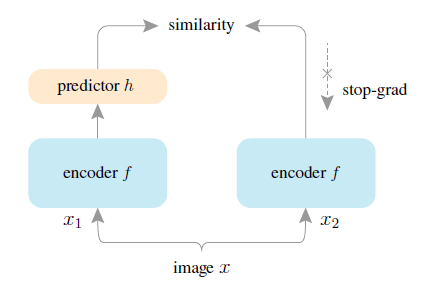<br/>
Since we have lot of noise in our data, I thought of visualizing how noisy the data is!
So, I used t-sne on the representations obtained from this model and visualized in [this notebook](https://www.kaggle.com/saimanojakondi/explore-the-rep).

In [ ]:
!pip install efficientnet_pytorch
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
import torch
from torch import nn
import cv2
import numpy as np
import time
import random
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import os

from efficientnet_pytorch import EfficientNet
from torchvision import models
from torch.nn import functional as F

from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
import albumentations as A

In [ ]:
#paramters
train_dir= '../input/cassava-leaf-disease-classification/train_images'
test_dir = '../input/cassava-leaf-disease-classification/test_images'
cfg = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'epochs':25,
    'batch_size':68,
    'lr':0.0001,
    'input_size':256,
    
}

In [ ]:
imagenames = [name for name in os.listdir(train_dir)]
csv = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
print(csv.head(10))
print(csv['label'].unique())

In [ ]:
def add_guassian_noise(image): 
    return IAAAdditiveGaussianNoise(p=1.0,loc=1.3,scale=(0,255),per_channel=True)(image=image)['image']
def cutout(image):
    return A.augmentations.transforms.Cutout(num_holes=10, max_h_size=10, max_w_size=10, fill_value=0, always_apply=False, p=1.0)(image=image)['image']
def get_train_transforms():
    return Compose([
            RandomResizedCrop(cfg['input_size'], cfg['input_size'],scale=(0.3,1)),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.2),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ], p=1.)

def get_valid_transforms():
    return Compose([
            CenterCrop(cfg['input_size'], cfg['input_size'], p=1.),
            Resize(cfg['input_size'], cfg['input_size']),
        ], p=1.)


def normalize_and_to_tensor(img):
    transform = Compose([Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                       ToTensorV2(p=1.0)],p=1.0)
    return transform(image=img)['image']


class CASSAVA(Dataset):
    def __init__(self,
                 imagenames,
                 csv,
                 root_dir,
                 input_size=cfg['input_size'],
                 transforms=None,
                 train=True,
                contrastive = True):
        self.imagenames = imagenames
        self.csv = csv
        self.root_dir = root_dir
        self.input_size = input_size
        self.transforms = transforms
        self.train = train
        self.contrastive = contrastive
    def __len__(self):
        return len(imagenames)
    def get_onehot(self,label):
        onehot = np.zeros(5)
        onehot[label] = 1
        return onehot
    def __getitem__(self,idx):
        imagename = self.imagenames[idx]
        label = self.csv[self.csv['image_id']==imagename]['label']
        label = self.get_onehot(label)
        image = cv2.imread(self.root_dir+'/'+imagename)
        image = cv2.resize(image,(self.input_size,self.input_size))
        image_aug1 = self.transforms(image=image)['image']
        image_aug2 = self.transforms(image=image)['image']
        if random.choice([1,2])==1:
            image_aug1 = add_guassian_noise(image_aug1)
            image_aug2 = cutout(image_aug2)
        else:
            image_aug2 = add_guassian_noise(image_aug2)
            image_aug1 = cutout(image_aug1)
        label = torch.from_numpy(label)
        image = normalize_and_to_tensor(image)
        image_aug1 = normalize_and_to_tensor(image_aug1)
        image_aug2 = normalize_and_to_tensor(image_aug2)
        #image_aug3 = normalize_and_to_tensor(image_aug3)
        return image,image_aug1,image_aug2,label

In [ ]:
train_transforms = get_train_transforms()
t_dataset = CASSAVA(imagenames,csv,train_dir,transforms = train_transforms)
train_loader = DataLoader(dataset=t_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)

In [ ]:
backbone = models.resnet50(pretrained=False)
modules = list(backbone.children())[:-2]
backbone = nn.Sequential(*modules)
print(backbone)

In [ ]:
class CLASSIFIER(nn.Module):
    def __init__(self):
        super().__init__()
        self.effn = backbone
        self.average = nn.AvgPool2d((8,8))
        self.flatten = nn.Flatten()
        
    def forward(self,x):
        x = self.effn(x)
        x = self.average(x)
        x = self.flatten(x)
        #x = F.relu(self.projection(x))
        return x
    
class HEAD(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(2048,512)
        self.dense2 = nn.Linear(512,2048)
    def forward(self,x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        return x

Head = HEAD()
x = torch.randn((1,2048))
y = Head(x)
print(y.size())

model = CLASSIFIER()
x = torch.randn((1,3,256,256))
y = model(x)
print(y.size())

In [ ]:
count_parameters(model)
print("##"*12,'head')
count_parameters(Head)

In [ ]:
def cosine_similarity(y_true,y_pred):
    y_pred = y_pred.detach()
    y_true = y_true/(y_true.norm(dim=-1)[:,None]+1e-6)
    y_pred = y_pred/(y_pred.norm(dim=-1)[:,None]+1e-6)
    loss = y_true*y_pred
    loss = loss.sum(dim=-1)
    return -loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
model.to(cfg['device'])
Head.to(cfg['device'])
for epoch in range(cfg['epochs']):
    
    #epoch parameters
    epoch_loss = 0
    model.train()
    start = time.time()
    
    for i,(image2,image3,image4,label) in enumerate(tqdm(train_loader,total=train_loader.__len__(),ncols = 500)):
        
        #image1 = image1.to(cfg['device'])
        image2 = image2.to(cfg['device'])
        image3 = image3.to(cfg['device'])
        image4=  image4.to(cfg['device'])
        #represent
        rep3,rep4 =model(image3),model(image4)
        h3,h4 = Head(rep3),Head(rep4)
        
        #negativity similarity
        loss = (cosine_similarity(h3,rep4)+cosine_similarity(h4,rep3))/2

        #backprop
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        epoch_loss+=loss.mean().item()

    scheduler.step(epoch_loss/(i+1))
    print('Epoch {:03}: | Loss: {:.3f} | Training time: {}'.format(
            epoch + 1,  
            epoch_loss/(i+1), 
            str(time.time() - start)[:7]))
    torch.save(model.state_dict(), 'I_am_trained_{}_{}.pt'.format(epoch,epoch_loss/(i+1)))

In [ ]:
del model, optimizer, train_loader, scheduler,Head
torch.cuda.empty_cache()

In [ ]:
csv.shape